<h1 align="center">Telescope Data Structure used in AutoPHoT</h1> 

AutoPhOT is built to be used across any telescope and their instruments. Fits files *should* follow the fits standard naming convention, although we found thoughout developent that a database is needed to translate discrepancies in naming conventions from different telescopes/instrument.

As such, AutoPhOT creates a *telescope.yml* file in the directory given by **wdir**. **wdir** house the necasscary files for automated quick photometry.

This noteboook highlights the operation of the *teledata2yml* function in the call_datacheck packge in autophot.
Although this fucntion is executed during the *run* fucntion from autophot.autophot it can be executed beforehand such to take the care needed to build a reliable telescope/instrument database.

This script is used as more of a demonstartion (and the user should be aware of) rather than something the user needs to code up themselves. 

This function is executed everytime AutoPhOT is executed.

<div class="alert alert-danger">
  <strong>Remeber!</strong> All fits images need the TELESCOP and INSTRUME keywords
</div>



In [1]:
import autophot

# this is the function we will be checking out
from autophot.packages.call_datacheck import checkteledata

<h2 align="center">Create some fake FITS files</h2> 

For this demonstration we will create a folder on the users desktop and save the **fake_EFOSC2** and **fake_SOFI**. Although there is no need for the user to follow this notebook on their machine.

In [2]:
import os

# Get the users homepath
homedir = os.path.expanduser("~")

# Get path of their desktop
desktopdir = os.path.join(homedir,'Desktop')

# Get path of new directory called fake fits
wdir = os.path.join(desktopdir,'fake_fits')

# create direcrory called fake_fits
os.makedirs(wdir,exist_ok = True)

For the purpose of this example, we will make two files from the same  telescope, but from different instruments. The data will be a random image but we'll focusing on the header information.

For this demonstration we will make files from the NTT at La Silla which has EFOSC in sloan r and later in sloan g and SOFI in K band.
We will have EFOSC follow ideal header keycards whereas SOFI will follow a different paradigm.

In [3]:
from numpy import random
from astropy.io import fits

# Fake EFOSC file 
data = random.random((50,50))

hdu = fits.PrimaryHDU(data)
hdul = fits.HDUList([hdu])

fake_efosc_path = os.path.join(wdir,'Fake_EFOSC2.fits')

hdul.writeto(fake_efosc_path,overwrite = True)

# update fake_efosc2.fits with usual header keywords
with fits.open(fake_efosc_path,'update') as f:
    for hdu in f:
        hdu.header['TELESCOP'] = ('ESO-NTT','added for example')
        hdu.header['INSTRUME'] = ('EFOSC2','added for example')
        hdu.header['FILTER'] = ('r','added for example')
        hdu.header['EXPTIME'] = (60.0,'added for example')
        hdu.header['GAIN'] = (1.0,'added for example')
        hdu.header['MJD-OBS'] = (58849.,'added for example')

Lets check out this file we created

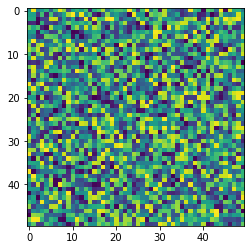

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                   50                                                  NAXIS2  =                   50                                                  EXTEND  =                    T                                                  TELESCOP= 'ESO-NTT '           / added for example                              INSTRUME= 'EFOSC2  '           / added for example                              FILTER  = 'r       '           / added for example                              EXPTIME =                 60.0 / added for example                              GAIN    =                  1.0 / added for example                              MJD-OBS =              58849.0 / added for example                              END                                     

In [4]:
from autophot.packages.functions import getimage,getheader
import matplotlib.pyplot as plt

image = getimage(fake_efosc_path)
header = getheader(fake_efosc_path)



fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.imshow(image)
plt.show()


print(header)

In [5]:
# Fake SOFI file 

data = random.random((50,50))

hdu = fits.PrimaryHDU(data)
hdul = fits.HDUList([hdu])

fake_sofi_path = os.path.join(wdir,'Fake_SOFI.fits')
hdul.writeto(fake_sofi_path,overwrite = True)

# update fake_sofi.fits with some unique header keywords
with fits.open(os.path.join(wdir,'Fake_SOFI.fits'),'update') as f:
    for hdu in f:
        hdu.header['TELESCOP'] = ('ESO-NTT','added for example')
        hdu.header['INSTRUME'] = ('S_O_F_I','added for example')
        hdu.header['FIL_WHL3'] = ('K_short','added for example')
        hdu.header['EXPTIME'] = (60.0,'added for example')
        hdu.header['GAIN_E'] = (1.0,'added for example')
        hdu.header['MJD-OBS'] = (58849.,'added for example')

<h2 align="center">Building Database</h2> 

We can now call the checkteledata and build the telescope.yml file. 

In [6]:
# create a list of filepaths  
flist = [fake_sofi_path,fake_efosc_path]
print('List of files:',flist)

List of files: ['/Users/seanbrennan/Desktop/fake_fits/Fake_SOFI.fits', '/Users/seanbrennan/Desktop/fake_fits/Fake_EFOSC2.fits']


In [7]:
# Load default synatx dictionary
from autophot.prep_input import load

# Load in command dictionary
autophot_input = load()


# Update working directory to parent directory of our fake images
autophot_input ['wdir'] = wdir

Default input loaded in from: 
/Users/seanbrennan/miniconda3/envs/autophot/lib/python3.7/site-packages/autophot/databases/default_input.yml


<h3 align="center">Checking telescope and instrument information</h3> 

In the cell below we will now check the files we have created and update our telescope.yml file with their information.

For both files we'll be asked (in order):

1. Telescope location: 

    This can be selected from a list (given by the Astropy package Astroplan) or enter the Altitude, lataitude and longitude of the observatory.
    

2. Telescope and Instrument label:

    This is used to neatly label the telescope and instrument images for easy recognition.
    

3. Gain Key: 

    The header keyword that gives the Image gain in $e^{-}$ per ADU.
    

4. Readnoise Key:

    The header keyword that gives the image readnoise in $e^{-}$ per pixel.
    

5. Airmass Key:

    The header keyword that gives the airmass of the observation.
    
<h4 align="center">Check for correct filter information</h4> 

Next AutoPHoT performs a check to make sure all nessecary filter information is available:

First it will search for the correct header keyword that corrospond to a distinct filter name. By default the code will search for any keywords similer to _FL_, _FIL_, or _FILTER_
    
Next it will ask (if needed) to confirm any ambiguois filter name When/if asked for corrospsonding filter name, filter name must be in this list:

Johnson-Cousion: UBVRI

SLOAN: ugriz

Near Infrared: JHK

For example rp $\rightarrow$ r, K_short $\rightarrow$ K, Bes_B $\rightarrow$ B
    

In [8]:
checkteledata(autophot_input,flist)

Found Telescopes:

 - ESO-NTT
Adding new Telescope: ESO-NTT
Do you want to update location of ESO-NTT 
( Press enter for n ) 
( Accepted answers - y or n )
> 
-> n

 *** Instrument Found ***
ESO-NTT -> INSTRUME -> S_O_F_I
Enter name of Telescope and Instrument for labelling 
( Press enter for ESO-NTT+S_O_F_I ) 
> 
-> ESO-NTT+S_O_F_I
Enter Pixel scale in arcsec/pixel 
( Press enter for 0.4 ) 
> 
-> 0.4

Similar GAIN keywords found (File: Fake_SOFI.fits) 

Index - Key - value
1 - GAIN_E - 1.0  
Select index that represents GAIN key in e/ADU, type skip to give header key  
( Press enter for 1 ) 
> 
-> 1
GAIN key == GAIN_E

Cannot find any keywords similar to READNOISE (File: Fake_SOFI.fits)
Enter header key that represents READNOISE key in e/pixel, type skip to give header key  
( Press enter for ignore ) 
> 
-> ignore

Cannot find any keywords similar to AIRMASS (File: Fake_SOFI.fits)
Enter header key  that represents AIRMASS key , type skip to give header key  
( Press enter for ignore 

Great! The required information for both files is now written to _telescope.yml_.

Now that that files have been checked, if we rerun the function it won't ask up for any new entries.

In [9]:
checkteledata(autophot_input,flist)

Found Telescopes:

 - ESO-NTT

-> Telescope check complete

Checking Filter keywords and database

-> Filter check complete







Now that the telescope.yaml file has been great we can look it by loading the nest dictionary using yaml.safe_load and printing it with yaml.dump to check file structure - of course if this file is set up incorrectly you can edit it simply with a text editor

<h3 align="center">Checking general structure of telescope.yml</h3> 


In [10]:
import yaml

# The code will look for the telescope.yml in the wdir key given in the syntax
telescope_yaml_path = os.path.join(wdir,'telescope.yml')

with open(telescope_yaml_path, 'r') as f:
    yaml_data = yaml.safe_load(f)
    
print(yaml.dump(yaml_data, allow_unicode=True, default_flow_style=False))

ESO-NTT:
  INSTRUME:
    EFOSC2:
      AIRMASS: null
      GAIN: GAIN
      Name: ESO-NTT+EFOSC2
      RDNOISE: null
      filter_key_0: FILTER
      pixel_scale: 0.4
      r: r
    S_O_F_I:
      AIRMASS: null
      GAIN: GAIN_E
      K_short: no_filter
      Name: ESO-NTT+S_O_F_I
      RDNOISE: null
      filter_key_0: FILTER
      filter_key_1: FIL_WHL3
      pixel_scale: 0.4
  location:
    alt: null
    lat: null
    lon: null
    name: null

